## 본 구문
    - 과거 lot 별 공정데이터 확인용 (추후 다른 컴파운드도 가능)
    - column 약어 설명
        * Step_No : 배치 별 공정 step
        * Temp : 컴파운드 온도
        * Rt_RPM : Rotor RPM
        * Rt_Cl	: Rotor Clearance (로터 간격)
        * RAM_Pr : RAM Pressure
        * RAM_st : RAM 위치 (z 좌표)
        * Amp : amphere 
    - bat_no: [생산년월, batch수] , 511건
    - bat_list: [batch_no, 각 batch의 시작시간(timestamp)] 9건

In [45]:
import os
import time                              ## 작업 시 소요시간을 체크하기 위함 (본 구문에 start, end 로 계산)
from datetime import datetime 
import pandas as pd
import numpy as np
from matplotlib import dates
import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
# 시작시간
start = time.time()

# define 된 함수에서 각각 xls를 읽어낸 후 Dataframe 생성하게 되면,
# 이를 기존 DataFrame에 concat으로 붙이기 위해서 아무것도 없는 빈 행을 가진 DataFrame을 하나 만들어둠
# 맨 마지막에 이 행은 삭제해야 함

test2=['0'] 
result2=pd.DataFrame(test2)
result2.columns=['배합']

# 불러올 xls 파일들이 있는 경로 지정
path1= "./MR-1303"                           ## 파일들이 담겨있는 folder 주소
list_csv = os.listdir(path1)               ## 해당 폴더의 파일목록을 list_1에 입력

# xls 파일 하나씩 불러오면서 DataFrame 생성
lot_no=[]                                  ## 파일명의 앞 4자리(연월)을 list로 저장
for lis in list_csv:
    result1=pd.read_excel(path1+'/'+lis)
    
    result1.columns=['Batch_No1','배합','설비1','설비2','일시1','진행스텝',
'Step_No','수지온도','Temp','로터회전속도','Rt_RPM','Rotor_간격','Rt_Cl','RAM압력','RAM_Pr','RAM위치','RAM_st','부하','Amp']
    result1=result1.astype({'Batch_No1':str}) 
    result1["Batch_No1"]=result1["Batch_No1"].str.zfill(2)
    result1=result1.astype({'Step_No':int})  
    result1['Batch_No']=str(lis[0:4])+'_'+result1['Batch_No1']  ## Batch별로 그래프 확인하기 위한 변수 설정
    tmtm=[]
    for tt in range(len(result1)):                              ## 기존 자료의 일시를 datetime 형식으로 변환
        year=int(result1['일시1'][tt][0:4])
        month=int(result1['일시1'][tt][5:7])
        day=int(result1['일시1'][tt][8:10])
        if "오후" in result1['일시1'][tt]:                       ## 기존 형식에 오전/오후 구분되어 있어 문제가 발생하지 않도록 처리하는 구문
            if int(result1['일시1'][tt][-8:-6])==12:            ## 오전 12시 --> 0시, 오후 12시 -->12시로 표현해야 함 (오전/오후 --> 24hr로 변경)
                hour=12
            else:
                hour=int(result1['일시1'][tt][-8:-6])+12
                
        else:
            if int(result1['일시1'][tt][-8:-6])==12:
                hour=0
            else:
                hour=int(result1['일시1'][tt][-8:-6])
        minute=int(result1['일시1'][tt][-5:-3])
        second=int(result1['일시1'][tt][-2:])
        tmtm.append(datetime(year, month, day, hour, minute, second))
    result1['일시']=tmtm
    result2=pd.concat([result1,result2])
    lot_no.append(str(lis[0:4]))

result2.reset_index(drop=True, inplace=True)          ## 인덱스 리셋
result2.drop(len(result2)-1, inplace=True)            ## 마지막행 삭제
result2.drop(['배합','Batch_No1','진행스텝','수지온도','로터회전속도','Rotor_간격','RAM압력','RAM위치','부하'], axis=1, inplace=True)            ## 마지막행 삭제

# 종료시간
end = time.time()

# 설명
print("소요시간: %d분 %0.2f초" %((end - start)//60, (end - start)%60))

## bat_no: [생산년월(=lot_no), lot별 batch수]
## bat_list: [batch_no, 각 batch의 시작시간(timestamp)]
bat_list=result2['Batch_No'].unique().tolist()  ## 'Batch_No' Column의 중복값 추리고 리스트로 변경
bat_no=[]
for ln in lot_no:    
    len_bat=len([bn for bn in bat_list if ln in bn])    
    bat_no.append([ln,len_bat])
for i in range(len(bat_list)):
    bat_list[i]=[bat_list[i],result2['일시'][result2['Batch_No']==bat_list[i]].iloc[0]]
    
result2['일시2']=result2['일시']                        ## 가공시간을 구하기 위해서는 각 배치별 첫번째 시간으로 해당 배치를 모두 계산해줘야 함. for 구문으로 가면 10분 정도 소요되는데, 이와 같은 코드를 쓰면 수 초 이내 소요되어 시간단축됨
for i in range(len(bat_list)):
    result2.loc[result2['Batch_No'] == bat_list[i][0], '일시2'] = bat_list[i][1]

result2['가공시간']=result2['일시']-result2['일시2']          ## timedelta 형식이 됨

result2['가공시간2']=result2['가공시간'].dt.seconds                      ## 초(sec) 로 변환하여 int 형태로 저장 (timedelta 형태의 '가공시긴'을 x축으로 둘 때 뭔가 이상함


lot_list = result2['Batch_No'].unique().tolist()                  ## bat_list 중 첫번째

## batch_no 별 각 step의 시작 시간을 DataFrame으로 저장
## 추후에 그래프에서 step 의 시간 차이를 시각화 가능하도록
## step 0은 버리자

result3=result2.groupby(['Batch_No','Step_No']).min()['일시']
#result3=result2.groupby(['Batch_No','Step_No']).min()['일시']
result3a=pd.DataFrame(result3)
result3b=result3a.unstack().T                 ## 멀티index의 두번째 index를 column으로 재배열
result3b.drop([0.0],axis=0, level=1, inplace=True)          ## 멀티index에서 행삭제
result3b.drop(['1902_00'],axis=1, inplace=True)          ## 멀티index에서 행삭제

result3b=result3b.bfill()                   # 앞쪽으로 채우기(Forward-fill)
result3b=result3b.ffill()                   # 뒤쪽으로 채우기(Back-fill)
#result3b



소요시간: 0분 29.55초


Batch_No               1902_01             1902_02             1902_03  \
   Step_No                                                               
일시 1.0     2019-02-12 17:39:51 2019-02-12 16:50:22 2019-02-12 17:10:05   
   2.0     2019-02-12 16:33:06 2019-02-12 16:50:43 2019-02-12 17:10:21   
   3.0     2019-02-12 16:38:17 2019-02-12 16:54:30 2019-02-12 17:15:00   
   4.0     2019-02-12 16:40:11 2019-02-12 16:56:13 2019-02-12 17:16:46   
   5.0     2019-02-12 16:42:37 2019-02-12 16:58:59 2019-02-12 17:18:41   
   6.0     2019-02-12 16:46:01 2019-02-12 17:02:35 2019-02-12 17:22:19   
   7.0     2019-02-12 16:49:55 2019-02-12 17:03:33 2019-02-12 17:23:19   
   8.0     2019-02-12 16:49:55 2019-02-12 17:03:33 2019-02-12 17:23:19   

Batch_No               1902_04             1902_05             1902_06  \
   Step_No                                                               
일시 1.0     2019-02-12 17:23:46 2019-02-12 17:40:33 2019-02-12 17:52:09   
   2.0     2019-02-12 17:24:07 2019-02-12 17:40:33 2019-02-12 17:52:27   
   3.0     2019-02-12 17:27:32 2019-02-12 17:43:45 2019-02-12 17:56:09   
   4.0     2019-02-12 17:29:14 2019-02-12 17:45:33 2019-02-12 17:57:46   
   5.0     2019-02-12 17:30:50 2019-02-12 17:47:04 2019-02-12 17:59:18   
   6.0     2019-02-12 17:34:30 2019-02-12 17:50:43 2019-02-12 18:02:53   
   7.0     2019-02-12 17:35:28 2019-02-12 17:51:37 2019-02-12 18:03:52   
   8.0     2019-02-12 17:35:28 2019-02-12 17:51:37 2019-02-12 18:03:52   

Batch_No               1902_07             1902_08             1902_09  \
   Step_No                                                               
일시 1.0     2019-02-12 18:04:25 2019-02-12 18:16:43 2019-02-12 18:28:36   
   2.0     2019-02-12 18:04:40 2019-02-12 18:16:58 2019-02-12 18:28:51   
   3.0     2019-02-12 18:08:17 2019-02-12 18:20:38 2019-02-12 18:32:28   
   4.0     2019-02-12 18:09:51 2019-02-12 18:22:18 2019-02-12 18:34:03   
   5.0     2019-02-12 18:11:36 2019-02-12 18:23:22 2019-02-12 18:35:24   
   6.0     2019-02-12 18:15:12 2019-02-12 18:26:59 2019-02-12 18:38:56   
   7.0     2019-02-12 18:16:10 2019-02-12 18:28:03 2019-02-12 18:39:59   
   8.0     2019-02-12 18:16:10 2019-02-12 18:28:03 2019-02-12 18:39:59   

Batch_No               1902_10  ...             2303_83             2303_84  \
   Step_No                      ...                                           
일시 1.0     2019-02-12 18:58:23  ... 2023-03-04 10:40:38 2023-03-04 10:55:48   
   2.0     2019-02-12 18:58:39  ... 2023-03-04 10:40:59 2023-03-04 10:56:03   
   3.0     2019-02-12 19:03:12  ... 2023-03-04 10:44:38 2023-03-04 11:00:03   
   4.0     2019-02-12 19:05:00  ... 2023-03-04 10:45:40 2023-03-04 11:01:09   
   5.0     2019-02-12 19:07:14  ... 2023-03-04 10:47:01 2023-03-04 11:02:21   
   6.0     2019-02-12 19:10:46  ... 2023-03-04 10:50:21 2023-03-04 11:05:30   
   7.0     2019-02-12 19:11:45  ... 2023-03-04 10:54:16 2023-03-04 11:09:30   
   8.0     2019-02-12 19:11:45  ... 2023-03-04 10:55:17 2023-03-04 11:10:31   

Batch_No               2303_85             2303_86             2303_87  \
   Step_No                                                               
일시 1.0     2023-03-04 11:11:02 2023-03-04 11:25:57 2023-03-04 11:40:31   
   2.0     2023-03-04 11:11:17 2023-03-04 11:26:12 2023-03-04 11:40:46   
   3.0     2023-03-04 11:15:02 2023-03-04 11:30:13 2023-03-04 11:44:36   
   4.0     2023-03-04 11:16:03 2023-03-04 11:31:20 2023-03-04 11:45:38   
   5.0     2023-03-04 11:17:15 2023-03-04 11:32:31 2023-03-04 11:46:49   
   6.0     2023-03-04 11:20:29 2023-03-04 11:35:05 2023-03-04 11:49:43   
   7.0     2023-03-04 11:24:25 2023-03-04 11:38:59 2023-03-04 11:53:33   
   8.0     2023-03-04 11:25:26 2023-03-04 11:40:00 2023-03-04 11:54:34   

Batch_No               2303_88             2303_89             2303_90  \
   Step_No                                                               
일시 1.0     2023-03-04 11:55:05 2023-03-04 12:11:26 2023-03-04 12:25:29   
   2.0     2023-03-04 1

In [230]:
#result2.head()                  ## raw data를 정리, DataFrame
#result3b.head()                 ## 각 batch 별 step의 시작 시간 timestamp, DataFrame

In [227]:
#lot_no                   ## lot번호(연월, 4자리), list
#bat_no                  ## [생산년월(=lot_no), lot별 batch수], list
#bat_list                ## [batch_no, 각 batch의 시작시간(timestamp)], list

## 그래프 - Batch 별 Temp./Amp.
    - 각 그래프별로 시간에 따른 온도와 부하(amphere) 표현 (이중축)
    - 각 그래프별로 step별 시간 확인을 위해 영역을 다른 색깔로 표현

In [80]:
# 한글 깨짐 문제 해결용
from matplotlib import font_manager, rc
plt.rcParams["axes.unicode_minus"] = False
path = "C:\Windows\Fonts\H2GTRM.TTF"
font_name = font_manager.FontProperties(fname=path).get_name()
rc("font", family=font_name)

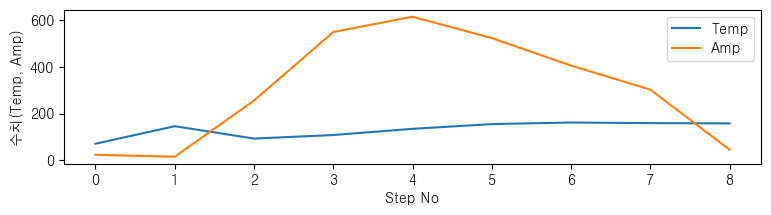

In [95]:
## test
ax = result2.groupby(["Step_No"])[["Temp", "Amp"]].mean().plot(figsize=(9, 2))
ax.set_ylabel("수치(Temp, Amp)")
ax.set_xlabel("Step No")
plt.show();

* 평균값은 의미없음

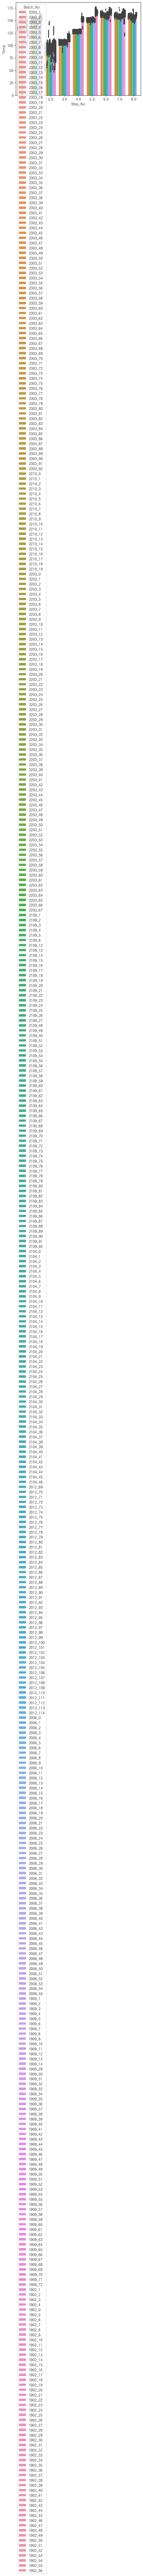

In [98]:
## 오래걸려서 나온 결과라 놔두기는 하는데 큰 의미는 없는 그래프

sns.barplot(x='Step_No', y='Temp', hue='Batch_No', data=result2)
plt.show()

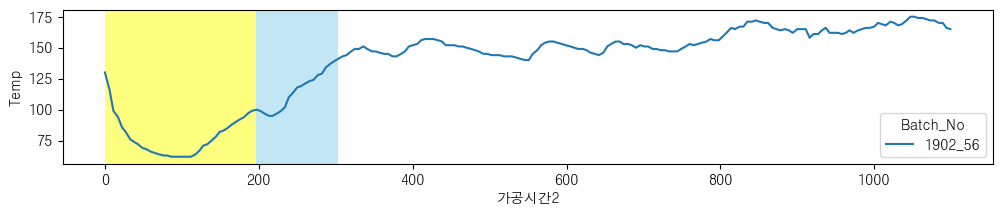

In [231]:
# 한개만 우선 표현 - test
bn='1902_56'
for blist in range(len(bat_list)):  ## 해당 batch(bn)의 최초 시간 불러오기 : bnt로 저장
    if bn == bat_list[blist][0]:
        bnt=bat_list[blist][1]
bnt_sec=(result3b[bn]-bnt).dt.seconds
plt.figure(figsize=(12, 2))
#sns.lineplot(x='일시', y='Temp', hue='Batch_No', data=result2[result2['Batch_No']=='2303_92'])
ax=sns.lineplot(x='가공시간2', y='Temp', hue='Batch_No', data=result2[result2['Batch_No']==bn])
plt.axvspan(bnt_sec[0],bnt_sec[1], facecolor='pink', alpha=0.5)           ## step 1
plt.axvspan(bnt_sec[1],bnt_sec[2], facecolor='yellow', alpha=0.5)         ## step 2
plt.axvspan(bnt_sec[2],bnt_sec[3], facecolor='skyblue', alpha=0.5)         ## step 3
plt.show()


Lot No:  ['1902', '1909', '2006', '2012', '2104', '2109', '2203', '2210', '2303']


그래프를 확인하고자 하는 Lot No를 입력해 주세요 2109


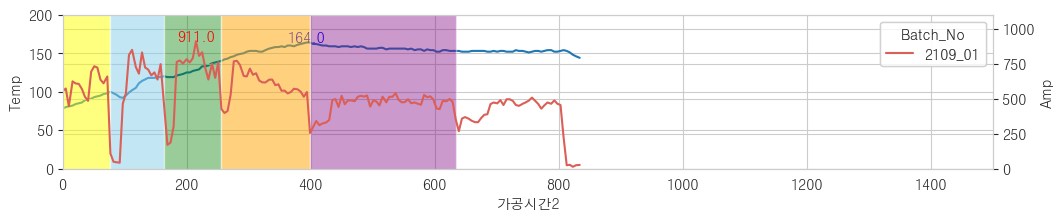

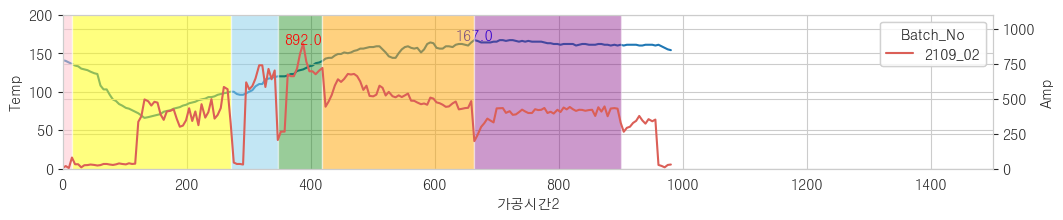

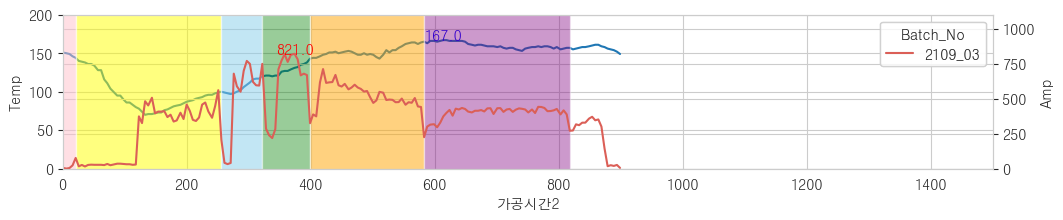

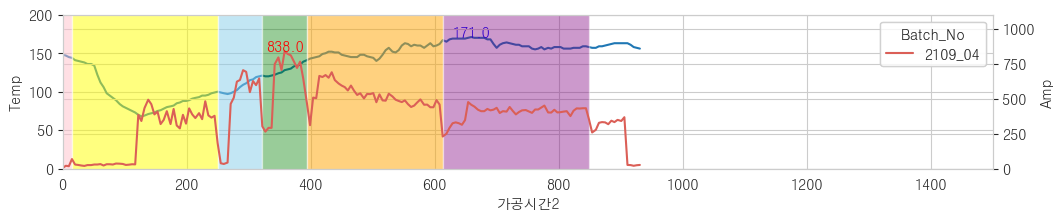

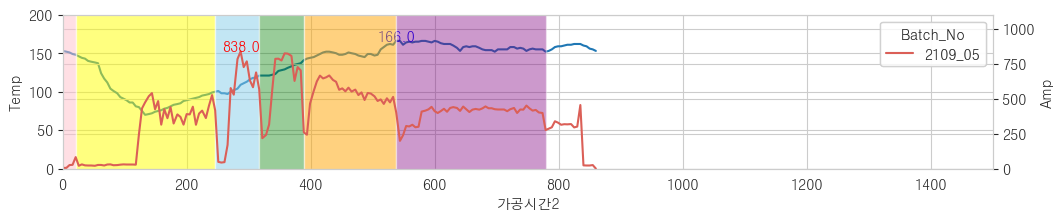

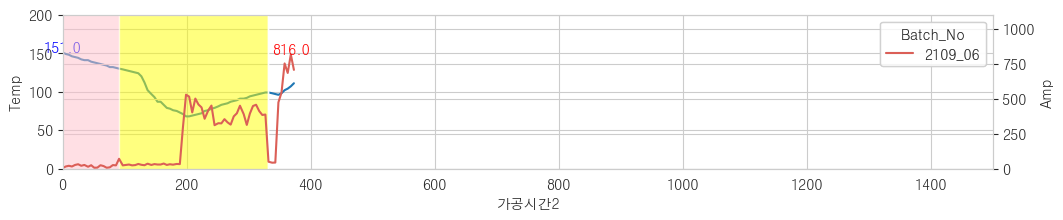

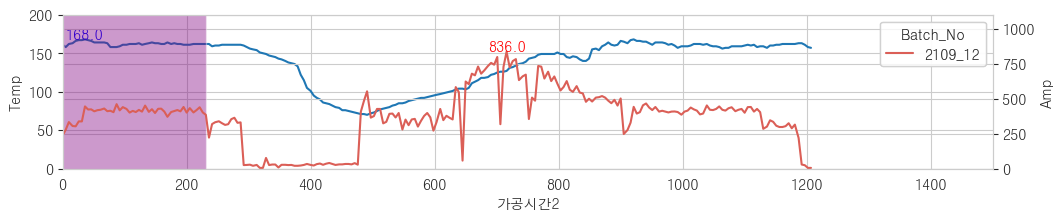

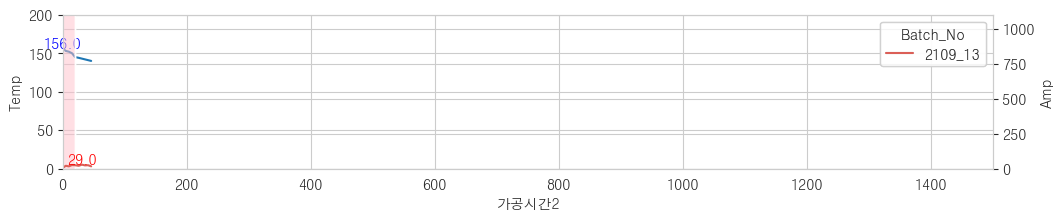

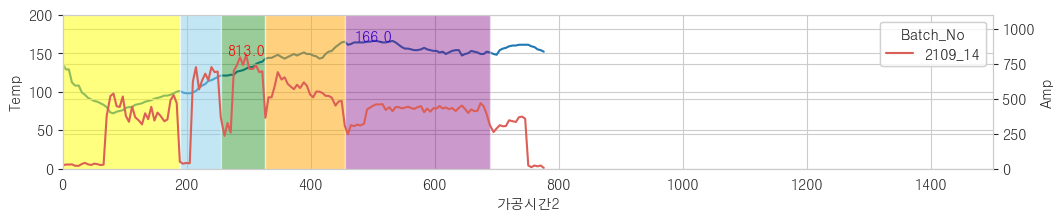

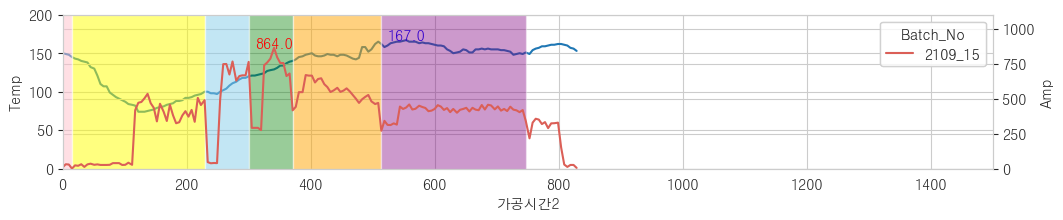

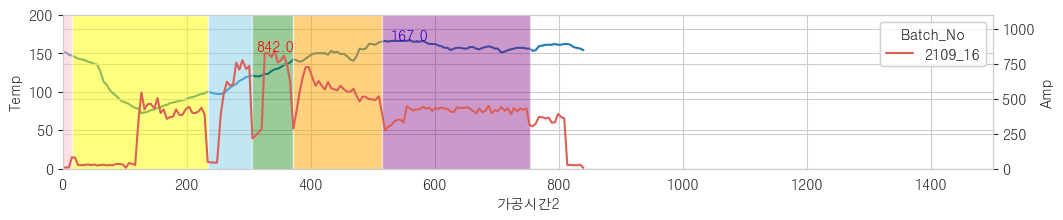

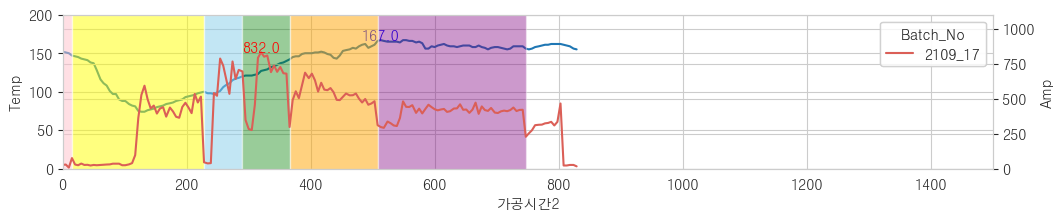

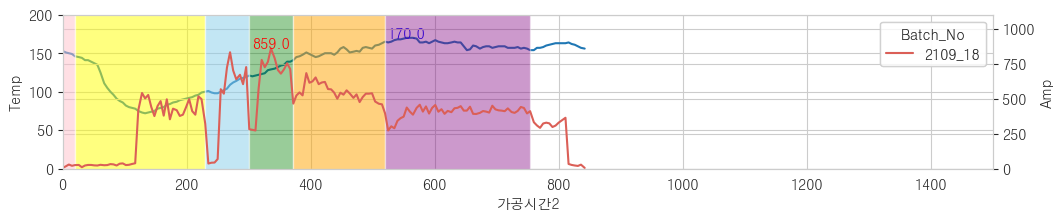

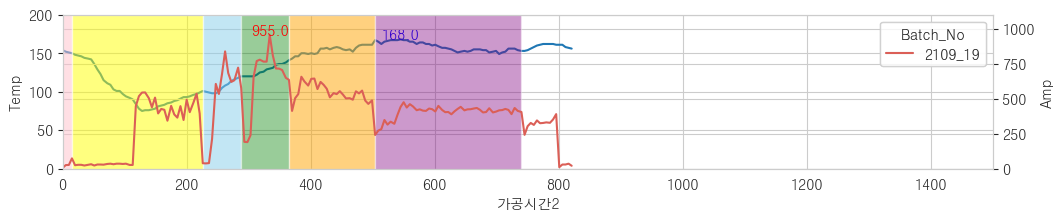

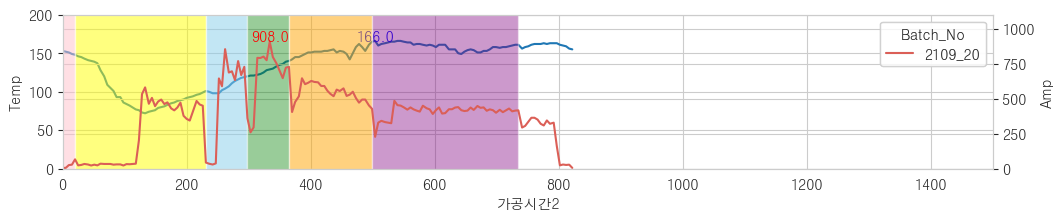

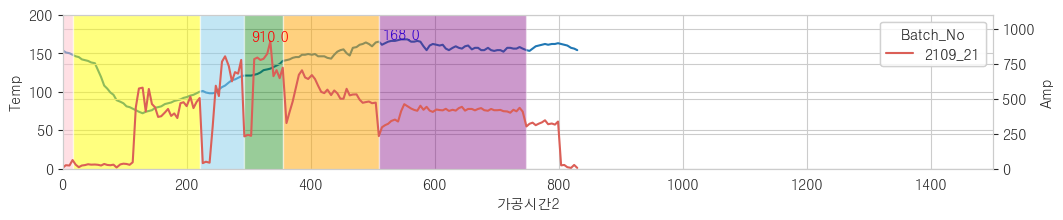

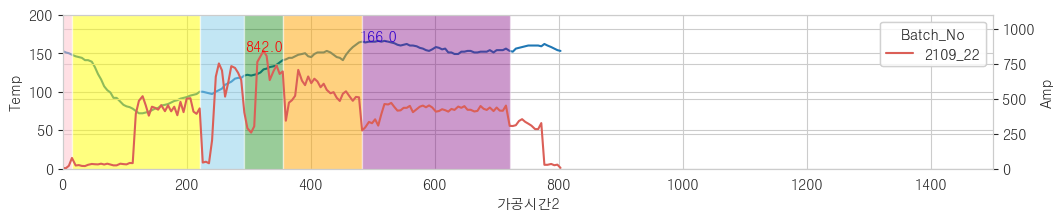

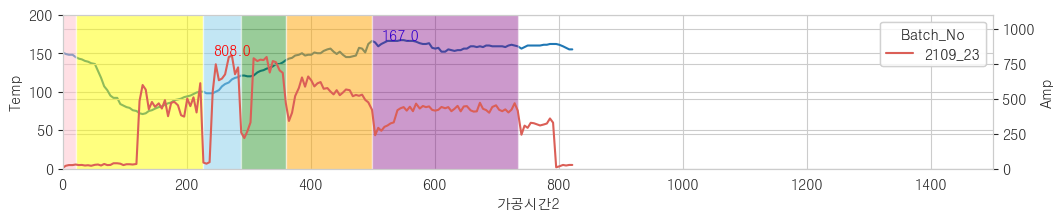

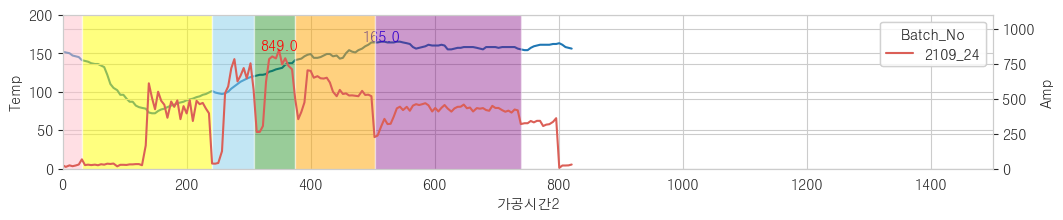

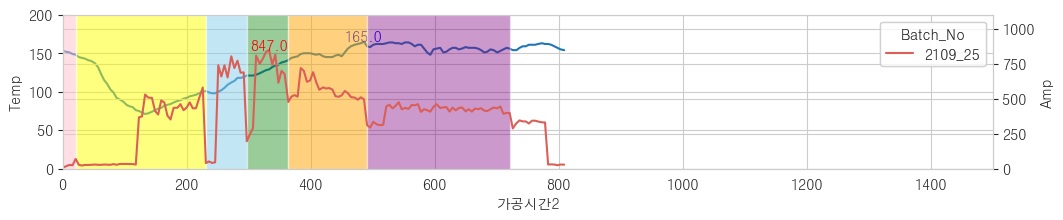

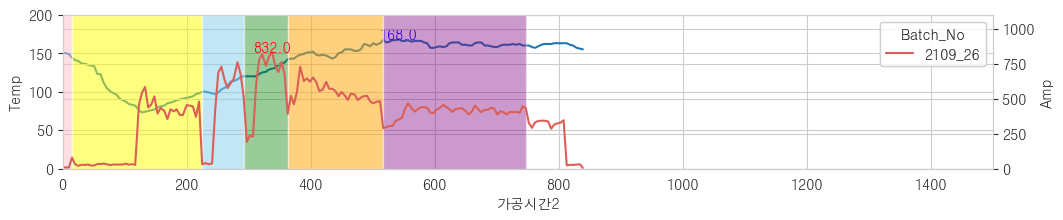

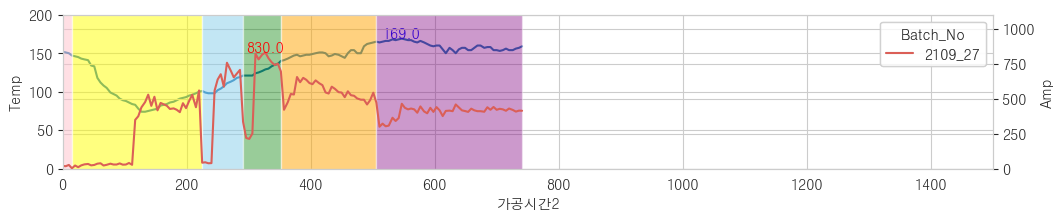

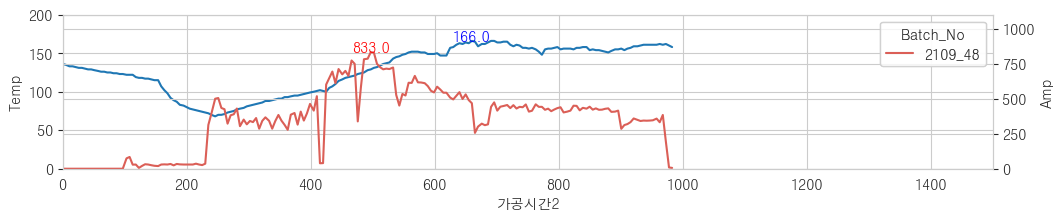

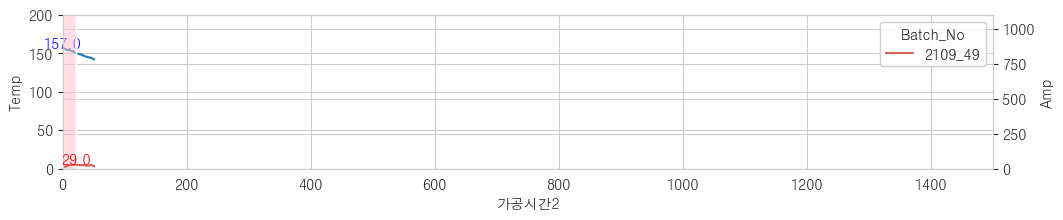

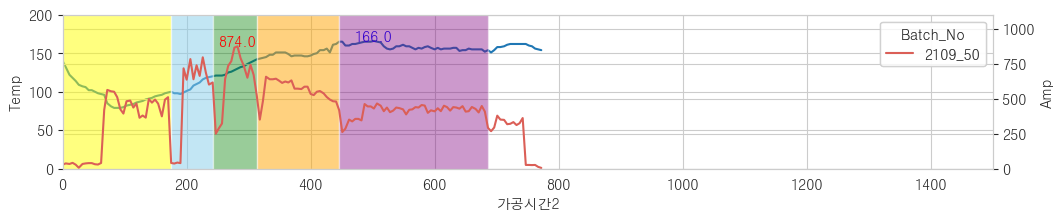

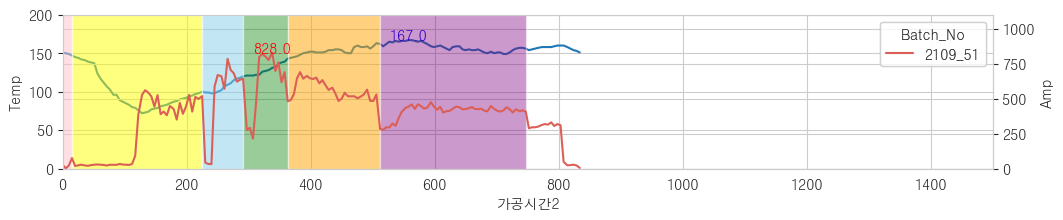

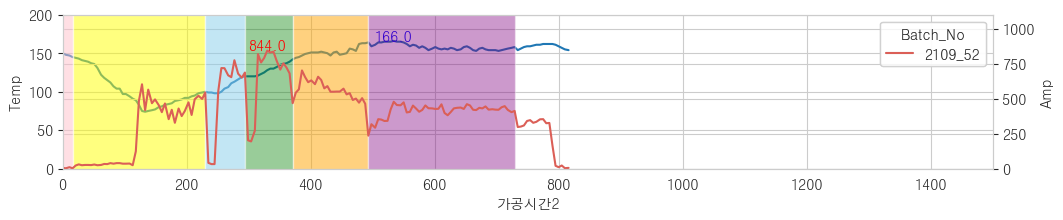

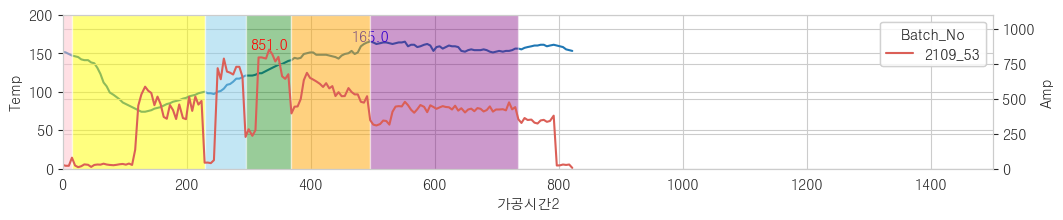

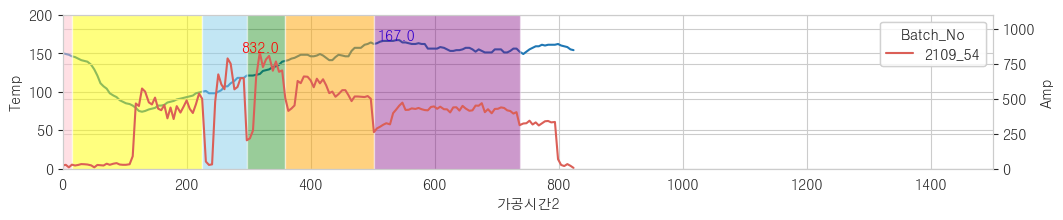

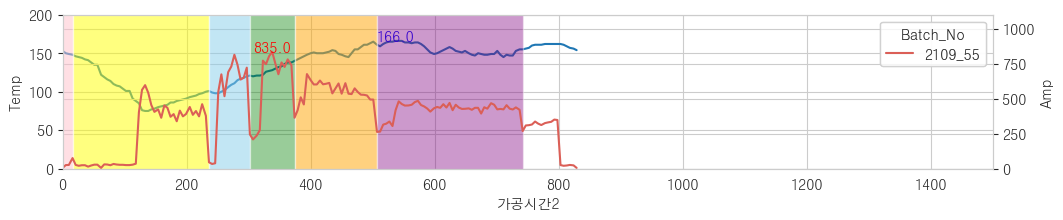

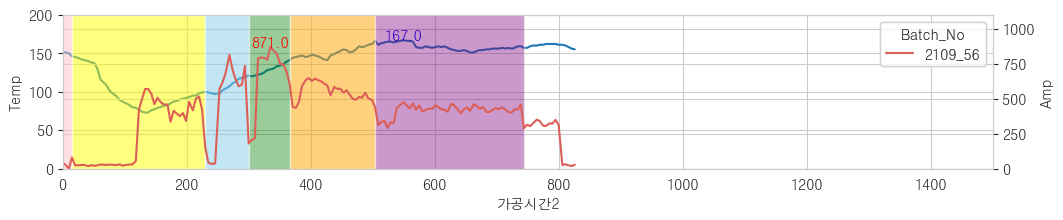

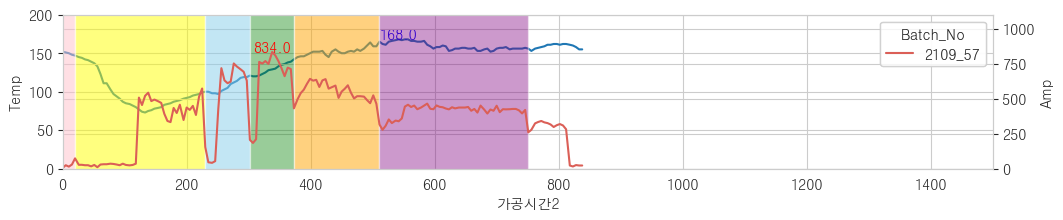

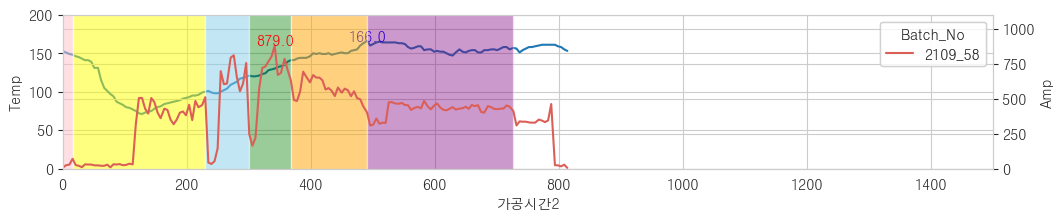

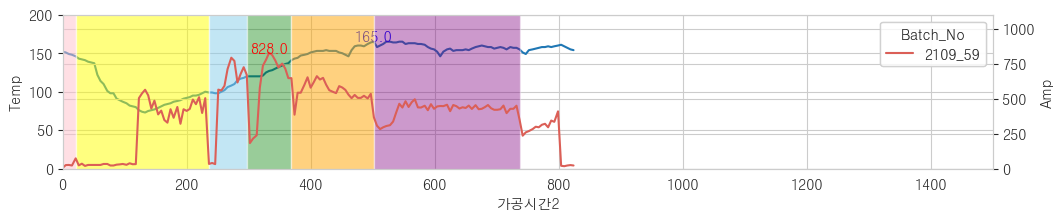

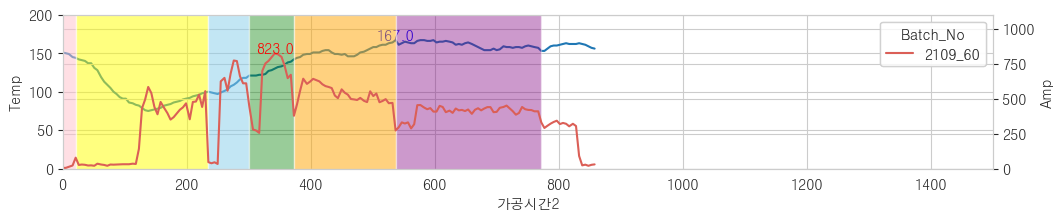

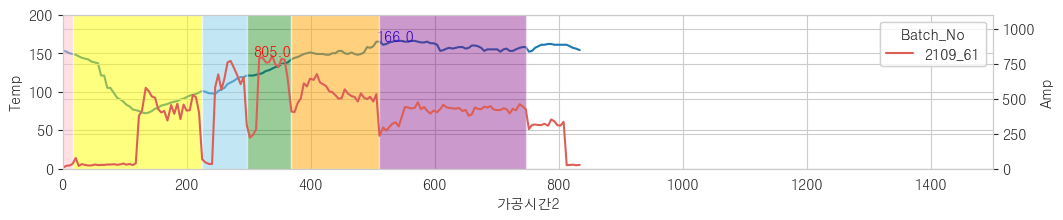

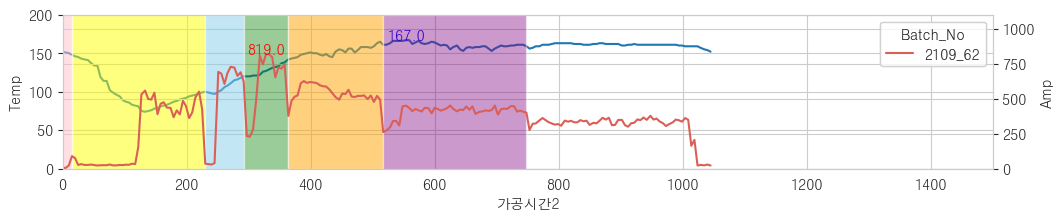

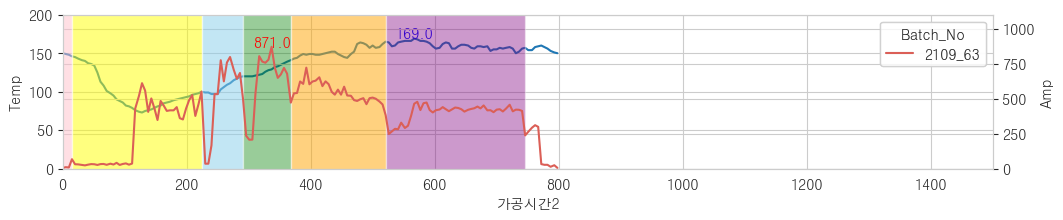

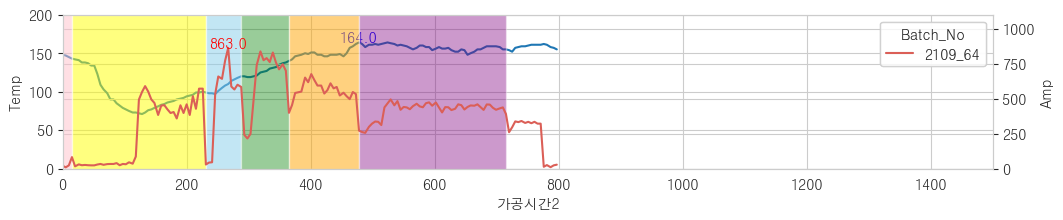

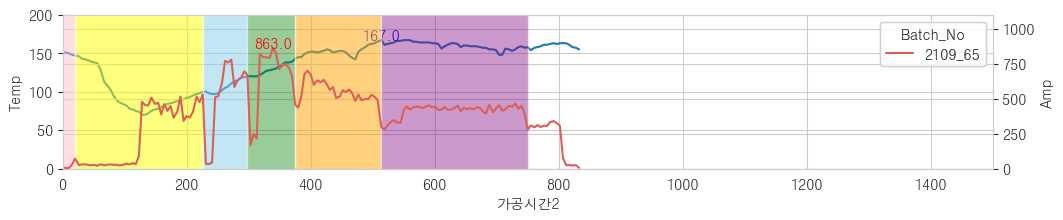

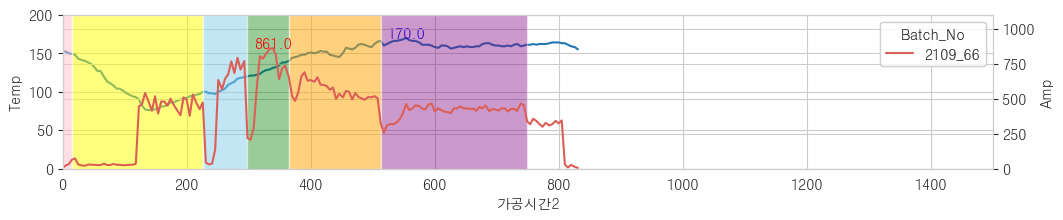

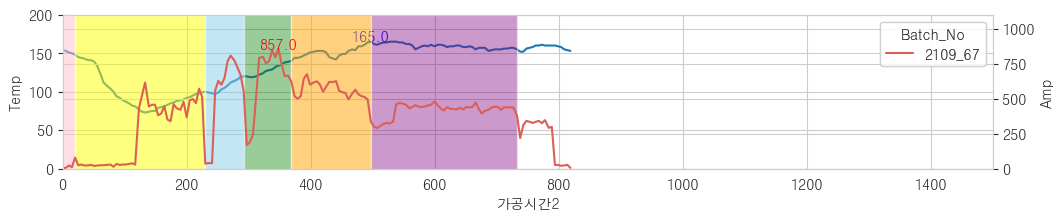

In [81]:
# 위 그래프를 같은 lot의 모든 batch에 대해 표현

print ('Lot No: ', lot_no)
ln=input ('그래프를 확인하고자 하는 Lot No를 입력해 주세요')  ## ln: 그래프를 확인하고자 하는 lot 번호

max_temp=result2.groupby(['Batch_No'])['Temp'].max()      ## 각 batch 별 최고 온도를 먼저 pandas.Series로 저장
max_amp=result2.groupby(['Batch_No'])['Amp'].max()        ## 각 batch 별 최고 온도를 먼저 pandas.Series로 저장

for inx in range(len(bat_no)):
    if ln==bat_no[inx][0]:
        ln2=bat_no[inx][1]                                ## ln2: ln 에 해당하는 lot의 총 batch 수


for bn in range(ln2):
    try:                                          ## raw data(xlsx 파일)을 확인하면 batch no가 붕 뜨는 경우가 종종 있음. 여기서 발생하는 error를 skip 하기 위해 try~ except 적용
        bnl=ln+'_'+str(bn+1).zfill(2)
        for blist in range(len(bat_list)):        ## 해당 batch(bn)의 최초 시간 불러오기 : bnt로 저장
            if bnl == bat_list[blist][0]:
                bnt=bat_list[blist][1]            ## 해당 batch(bn)의 시작 시간 불러오기 : bnt로 저장
        bnt_sec=(result3b[bnl]-bnt).dt.seconds    ## 해당 batch의 각 step별 시작시간에서 bnt를 빼고 sec로 단위 변환
    
    # 그래프에 max_temp, max_amp 를 표기하기 위한 계산 (각 max_temp, max_amp 값 및 해당 시간)
        mtb = max_temp[bnl]                                           ## 해당 batch의 max temp. 
        mtt=(result2['가공시간2'][result2['Batch_No']==bnl][result2['Temp']==mtb]).tolist()[0] ## max temp 찍었을 때의 시간 max temp. time
        mab = max_amp[bnl]                                            ## 해당 batch의 max amp. 
        mat=(result2['가공시간2'][result2['Batch_No']==bnl][result2['Amp']==mab]).tolist()[0] ## max amp 찍었을 때의 시간 max amp. time
    
    
        plt.rcParams['figure.figsize'] = (12, 2) 
    #fig=plt.figure(figsize=(12, 1))
    
        plt.xlim([0, 1500])      # X축의 범위: [xmin, xmax]
        plt.ylim([0, 200])       # y축의 범위: [ymin, ymax]
    
    #fig, axe1 = plt.subplots()
        c1=sns.lineplot(x='가공시간2', y='Temp', hue='Batch_No', palette='tab10',data=result2[result2['Batch_No']==bnl])
        plt.text(mtt, mtb, str(mtb), 
         color='blue', horizontalalignment='center', verticalalignment='baseline') #최고온도 표시

        c2 = c1.twinx()          # 이중축을 만들기 위한 시작
        plt.ylim([0, 1100])      # 두번째 y축의 범위: [ymin, ymax]
        c2=sns.lineplot(x='가공시간2', y='Amp', hue='Batch_No', palette='hls', data=result2[result2['Batch_No']==bnl])
        plt.text(mat, mab, str(mab), 
         color='red', horizontalalignment='center', verticalalignment='baseline') #최고 amphere 표시, 두번째 y축의 그래프 위에 표시하기 위한 plt.text 구문 (위치가 바뀌면 첫번째 그래프에 붙을 수 있음)

        plt.axvspan(bnt_sec[0],bnt_sec[1], facecolor='pink', alpha=0.5)           ## step 1
        plt.axvspan(bnt_sec[1],bnt_sec[2], facecolor='yellow', alpha=0.5)         ## step 2
        plt.axvspan(bnt_sec[2],bnt_sec[3], facecolor='skyblue', alpha=0.5)        ## step 3
        plt.axvspan(bnt_sec[3],bnt_sec[4], facecolor='green', alpha=0.4)          ## step 4
        plt.axvspan(bnt_sec[4],bnt_sec[5], facecolor='orange', alpha=0.5)         ## step 5
        plt.axvspan(bnt_sec[5],bnt_sec[6], facecolor='purple', alpha=0.4)         ## step 6
        plt.show()

    except:
        pass

## 그래프 - Scatter
    - 각 batch 별 max temp. vs max Amp. hue: batch
    - 각 batch 별 max temp. vs 도달 시간 hue: batch
    - 각 batch 별 max Amp. vs 도달 시간 hue: batch

In [33]:
## 그래프를 그리기 위한 데이터프레임 생성 (리스트(data3) 생성 후 DataFrame 전환(data3_df))

data3=[]
max_temp=result2.groupby(['Batch_No'])['Temp'].max()      ## 각 batch 별 최고 온도를 먼저 pandas.Series로 저장
max_amp=result2.groupby(['Batch_No'])['Amp'].max()        ## 각 batch 별 최고 온도를 먼저 pandas.Series로 저장



for bnl in lot_list:
    try:                                          ## raw data(xlsx 파일)을 확인하면 batch no가 붕 뜨는 경우가 종종 있음. 여기서 발생하는 error를 skip 하기 위해 try~ except 적용
        for blist in range(len(bat_list)):        ## 해당 batch(bn)의 최초 시간 불러오기 : bnt로 저장
            if bnl == bat_list[blist][0]:
                bnt=bat_list[blist][1]            ## 해당 batch(bn)의 시작 시간 불러오기 : bnt로 저장
        bnt_sec=(result3b[bnl]-bnt).dt.seconds    ## 해당 batch의 각 step별 시작시간에서 bnt를 빼고 sec로 단위 변환
    
        mtb = max_temp[bnl]                                           ## 해당 batch의 max temp. 
        mtt=(result2['가공시간2'][result2['Batch_No']==bnl][result2['Temp']==mtb]).tolist()[0] ## max temp 찍었을 때의 시간 max temp. time
        mab = max_amp[bnl]                                            ## 해당 batch의 max amp. 
        mat=(result2['가공시간2'][result2['Batch_No']==bnl][result2['Amp']==mab]).tolist()[0] ## max amp 찍었을 때의 시간 max amp. time
        data3.append([bnl,mtb,mtt,mab,mat])
    except:
        pass

## 리스트 중 0이 들어간 요소 찾기
del_list=[]                          ## 리스트 중 0이 들어간 batch는 삭제해버리기 위함. 나중에 DataFrame(data3_df)에서 행 자체를 삭제 예정
for j in range(len(data3)):
    if 0 in data3[j]:
        del_list.append(data3[j][0])
#del_list

## data3을 DataFrame으로 전환 (del_list(요소 중 0이 포함된 것) 삭제)
data3_df=pd.DataFrame(data3, columns=['Batch_No','maxT','maxT_time','maxA','maxA_time'])
data3_df['Lot']=data3_df['Batch_No'].str[0:4]
data3_df = data3_df.replace(0, np.NaN)
data3_df.dropna(inplace=True)
#data3_df

### Max Temp. vs time

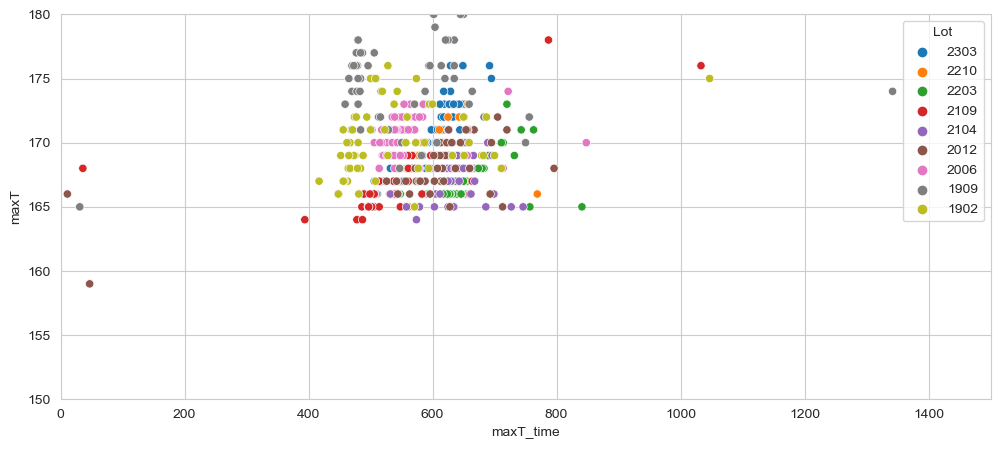

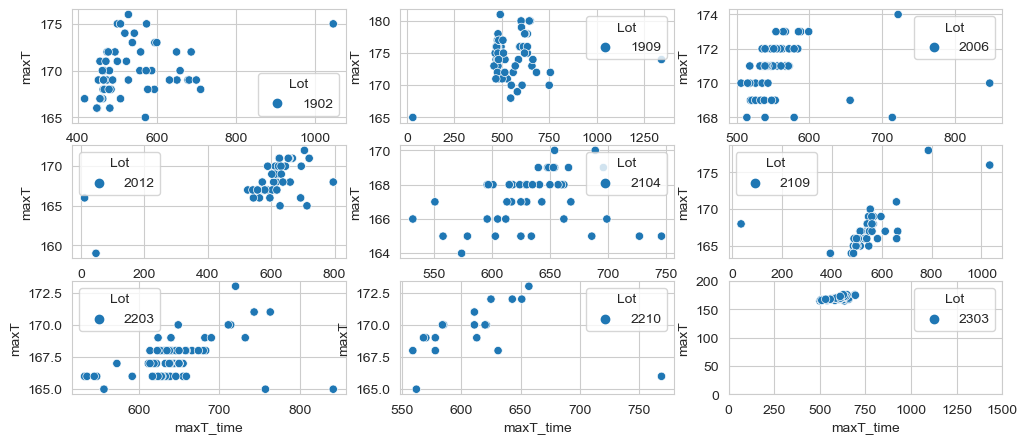

In [78]:
plt.rcParams['figure.figsize'] = (12, 5) 
plt.xlim([0, 1500])      # X축의 범위: [xmin, xmax]
plt.ylim([150, 180])       # y축의 범위: [ymin, ymax]
 

sns.set_style('whitegrid')
sns.scatterplot(data=data3_df, x='maxT_time', y='maxT',
                hue='Lot') ## 각 lot별 색상이 다르게 그려진다.
plt.show()

plt.rcParams['figure.figsize'] = (12, 5) 
fig, ax = plt.subplots(nrows=3,ncols=3)

sns.set_style('whitegrid')

axes=0
for i in range(3):
    for j in range(3):
        sns.scatterplot(data=data3_df[data3_df['Lot']==lot_no[axes]], x='maxT_time', y='maxT',hue='Lot', ax=ax[i,j])
        axes+=1
        plt.xlim([0, 1500])      # X축의 범위: [xmin, xmax]
        plt.ylim([0, 200])       # y축의 범위: [ymin, ymax]
        

plt.show()

### Max Amp. vs time

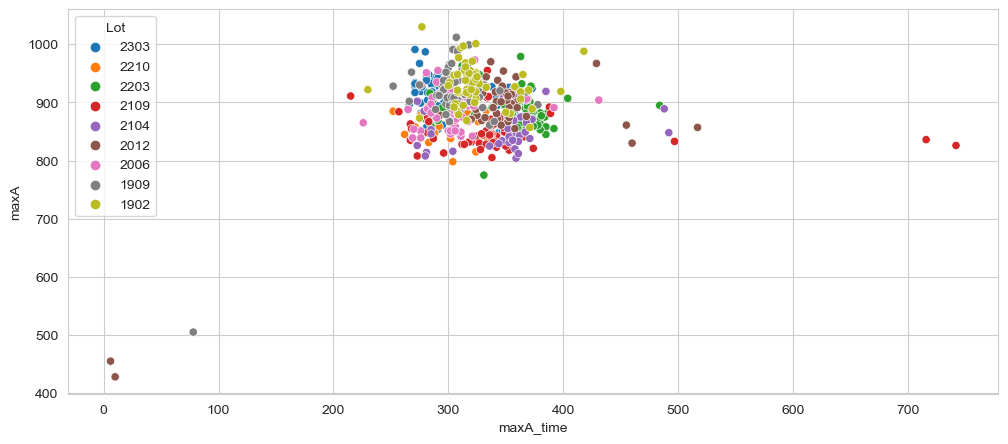

In [37]:
plt.rcParams['figure.figsize'] = (12, 5) 
sns.set_style('whitegrid')
sns.scatterplot(data=data3_df, x='maxA_time', y='maxA',
                hue='Lot') ## 각 lot별 색상이 다르게 그려진다.
plt.show()

### Max Amp. vs Max Temp.

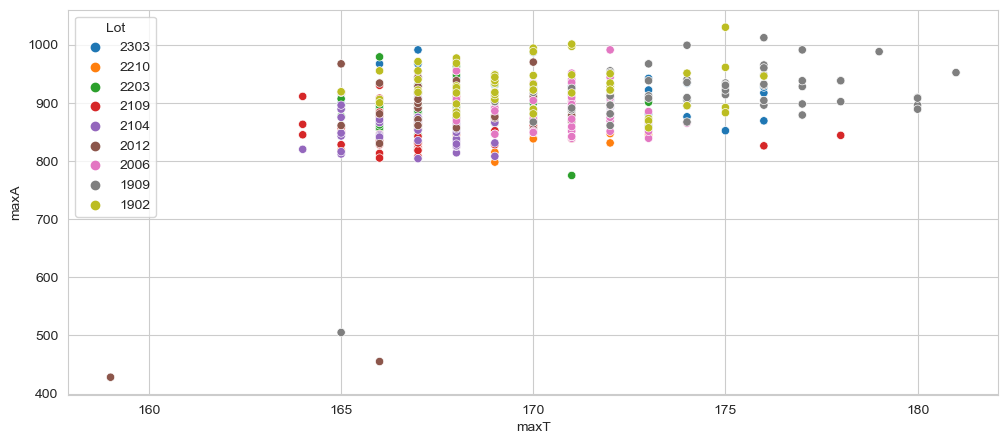

In [39]:
plt.rcParams['figure.figsize'] = (12, 5) 
sns.set_style('whitegrid')
sns.scatterplot(data=data3_df, x='maxT', y='maxA',
                hue='Lot') ## 각 lot별 색상이 다르게 그려진다.
plt.show()